In [42]:
import numpy as np
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import string

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

#import pytesseract
from pytesseract import Output

import shutil
#from keras.models import Sequential
from keras import optimizers
#from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
#from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import Xception
import imutils
#from google.colab.patches import cv2_imshow

from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
#https://www.mdpi.com/1999-4893/15/4/129

In [4]:
# Directory containing the training data
train_dir = "../character_dataset/Train2/"

# Directory containing the validation data
val_dir = "../character_dataset/Validation2/"

# Directory containing the validation data
test_dir = "../character_dataset/Test2/"

# List to store training data
train_data = []

# List to store validation data
val_data = []

# List to store test data
test_data = []

# Size of images
img_size = 32

# Dictionary to store label counts for training and validation data
train_label_counts = {}
val_label_counts = {}
test_label_counts = {}


### loading the training, validation and test dataset

In [5]:
def load_data_set(dir, data, label, limit=1000):
    # Iterate through each directory (class) in the main directory
    for i in os.listdir(dir):
        count = 0
        # Path to the sub-directory containing images for a particular class
        sub_directory = os.path.join(dir, i)
        
        # Iterate through each image in the sub-directory
        for j in os.listdir(sub_directory):
            count += 1
            
            # Limit the number of images per class to 4000
            if count > limit:  #4000
                break
            
            # Read and resize the image
            img = cv2.imread(os.path.join(sub_directory, j), 0)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))           # Resize image to desired dimensions
            
            # Append the image and its corresponding class label to the training data list
            data.append([img, i])

            # Increment label count
            label[i] = label.get(i, 0) + 1


In [6]:
# load train dataset and Count labels in training directories
load_data_set(train_dir, train_data, train_label_counts, 4000)
len(train_data)

75557

In [7]:
# load validation dataset and Count labels in validation directories
load_data_set(val_dir, val_data, val_label_counts, 1000)
len(val_data)

15099

In [8]:
# load test dataset and Count labels in test directories
load_data_set(test_dir, test_data, test_label_counts)
len(test_data)

3549

### Train, validation and test data distribution

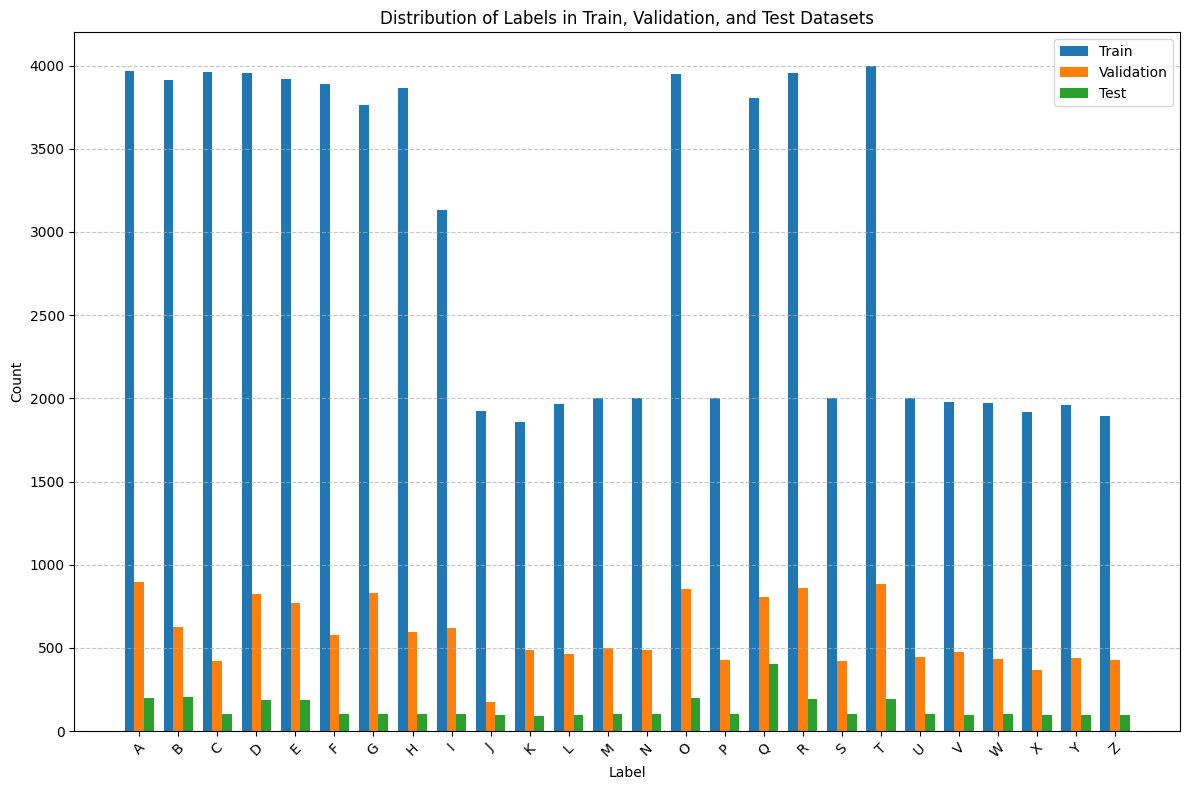

In [9]:
# Labels
labels = list(train_label_counts.keys())

# Count of labels for train, validation, and test datasets
train_counts = [train_label_counts[label] for label in labels]
val_counts = [val_label_counts.get(label, 0) for label in labels]
test_counts = [test_label_counts.get(label, 0) for label in labels]

# Plotting the distribution graph
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 8))
train_bars = ax.bar(x - width, train_counts, width, label='Train')
val_bars = ax.bar(x, val_counts, width, label='Validation')
test_bars = ax.bar(x + width, test_counts, width, label='Test')

ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels in Train, Validation, and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Shuffle the training data to introduce randomness
random.shuffle(train_data)

# Shuffle the validation data to introduce randomness
random.shuffle(val_data)

# Shuffle the test data to introduce randomness
random.shuffle(test_data)


In [11]:
# Initialize empty lists to store features and labels
train_X = []
train_Y = []

# Iterate through each data point in train_data
for features, label in train_data:
    # Append features to train_X list
    train_X.append(features)
    # Append label to train_Y list
    train_Y.append(label)

In [12]:
# Initialize empty lists to store features and labels
val_X = []
val_Y = []

# Iterate through validation data
for features, label in val_data:
    # Append features to val_X list
    val_X.append(features)
    # Append label to val_Y list
    val_Y.append(label)


In [13]:
# Initialize empty lists to store features and labels
test_X = []
test_Y = []

# Iterate through validation data
for features, label in test_data:
    # Append features to val_X list
    test_X.append(features)
    # Append label to val_Y list
    test_Y.append(label)

In [14]:
# Initialize a LabelBinarizer object
LB = LabelBinarizer()

# Fit the LabelBinarizer on the training labels and transform them
train_Y = LB.fit_transform(train_Y)

# Fit the LabelBinarizer on the validation labels and transform them
val_Y = LB.fit_transform(val_Y)

# Fit the LabelBinarizer on the test labels and transform them
test_Y = LB.fit_transform(test_Y)



### Feature engineering

In [15]:
# Normalize the pixel values of the training data by dividing by 255.0 to scale them between 0 and 1
train_X = np.array(train_X) / 255.0

# Reshape the training data to have dimensions (-1, 32, 32, 1) where -1 indicates the inferred value for the number of samples,
# 32x32 represents the dimensions of the images, and 1 represents the number of channels (grayscale)
train_X = train_X.reshape(-1, 32, 32, 1)

# Convert the training labels to a numpy array
train_Y = np.array(train_Y)


In [16]:
# Normalize the input data by dividing each pixel value by 255.0
val_X = np.array(val_X) / 255.0

# Reshape the input data to match the expected input shape of the model
val_X = val_X.reshape(-1, 32, 32, 1)

# Convert the labels to numpy array
val_Y = np.array(val_Y)

In [17]:
# Normalize the input data by dividing each pixel value by 255.0
test_X = np.array(test_X) / 255.0

# Reshape the input data to match the expected input shape of the model
test_X = test_X.reshape(-1, 32, 32, 1)

# Convert the labels to numpy array
test_Y = np.array(test_Y)

In [18]:
print(train_X.shape, val_X.shape, test_X.shape)
print(train_Y.shape, val_Y.shape, test_Y.shape)

(75557, 32, 32, 1) (15099, 32, 32, 1) (3549, 32, 32, 1)
(75557, 26) (15099, 26) (3549, 26)


In [19]:
# Early stopping callback to prevent overfitting and restore the best weights
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
filepath = 'savemodel/model_epoch_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.keras'
model_steps_checkpoints = ModelCheckpoint(filepath, save_best_only=False, monitor='val_accuracy', mode='max', verbose=1)

callbacks2 = [early_stopping, model_steps_checkpoints]

In [20]:
### model 1

### Model 1, overffitting issues

In [21]:
# Initialize a Sequential model
model = Sequential()

# Add a 2D convolutional layer with 32 filters, each of size (3, 3), ReLU activation, and input shape of (32, 32, 1)
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))

# Add a max-pooling layer with a pool size of (2, 2) to reduce spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 64 filters and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 128 filters and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer to randomly drop 25% of the units to prevent overfitting
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers into a 1D vector
model.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a dropout layer to randomly drop 20% of the units
model.add(Dropout(0.1))

# Add the output layer with 26 neurons (assuming it's a classification task with 26 classes) and softmax activation
model.add(Dense(26, activation='softmax'))


c:\Lambton\Term_2\BDM-2053 Big Data Algorithms and Statistics\labs\project\handwriting-recognition-model\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


#### model 2. Model tunning to solve overfitting

In [22]:
# Initialize a Sequential model
model = Sequential()

# Add a 2D convolutional layer with 32 filters, each of size (3, 3), ReLU activation, and input shape of (32, 32, 1)
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(32, 32, 1)))

# Add a max-pooling layer with a pool size of (2, 2) to reduce spatial dimensions
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 64 filters and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 128 filters and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer to randomly drop 25% of the units to prevent overfitting
model.add(Dropout(0.2))

# Flatten the output of the convolutional layers into a 1D vector
model.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a dropout layer to randomly drop 20% of the units
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout rate of 20%

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


# Add the output layer with 26 neurons (assuming it's a classification task with 26 classes) and softmax activation
model.add(Dense(26, activation='softmax'))


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,530 (662.23 KB)

 Trainable params: 169,530 (662.23 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the model with categorical crossentropy loss function,
# Adam optimizer, and accuracy metric
lr=1e-3
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

In [25]:
# Train the model using the training data for 50 epochs with a batch size of 32
# Also, validate the model's performance using the validation data
history = model.fit(train_X, 
                    train_Y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(val_X, val_Y),
                    callbacks=[callbacks2],
                    verbose=1)

Epoch 1/50
2360/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5296 - loss: 1.5652
Epoch 1: saving model to savemodel/model_epoch_01_val_accuracy_0.9070.keras
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.5299 - loss: 1.5644 - val_accuracy: 0.9070 - val_loss: 0.3307
Epoch 2/50
2360/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8911 - loss: 0.3884
Epoch 2: saving model to savemodel/model_epoch_02_val_accuracy_0.9262.keras
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.8911 - loss: 0.3884 - val_accuracy: 0.9262 - val_loss: 0.2755
Epoch 3/50
2361/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9186 - loss: 0.2991
Epoch 3: saving model to savemodel/model_epoch_03_val_accuracy_0.9334.keras
2362/2362 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - accuracy: 0.9186 - loss: 0.2991 - val_accuracy: 0.9334 - val_loss: 0.2575
Epoch 4/50
2359/2362 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9296 - loss: 0.2516
Epoch 4: saving model to savemodel/model_epoch_04_val

#### Save model

In [26]:
model.save('handwritten_model.keras')

### Traing and validation accuracy

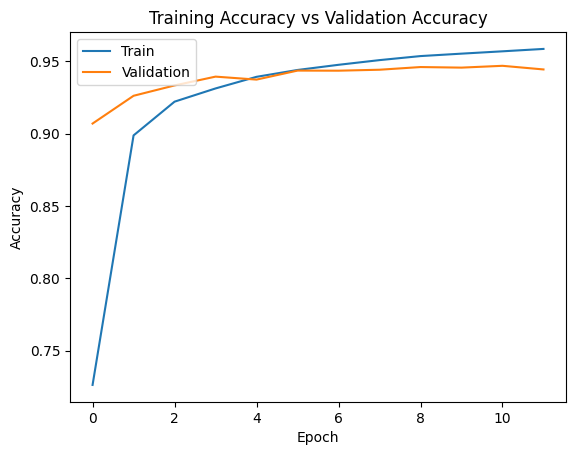

In [27]:
# Plotting the training accuracy and validation accuracy
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy

# Adding a title to the plot
plt.title('Training Accuracy vs Validation Accuracy')

# Labeling the y-axis as 'Accuracy'
plt.ylabel('Accuracy')

# Labeling the x-axis as 'Epoch'
plt.xlabel('Epoch')

# Adding a legend to distinguish between training and validation accuracy
plt.legend(['Train', 'Validation'], loc='upper left')

# Displaying the plot
plt.show()

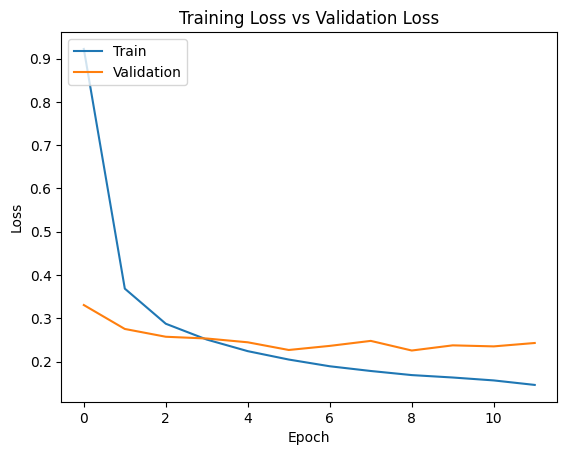

In [28]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation')  # Plot validation loss

plt.title('Training Loss vs Validation Loss')  # Set the title of the plot
plt.ylabel('Loss')  # Set the y-axis label to 'Loss'
plt.xlabel('Epoch')  # Set the x-axis label to 'Epoch'

# Add a legend with labels ('Train' and 'Validation') at the upper left corner
plt.legend(loc='upper left')

plt.show()  # Display the plot

In [29]:
# Extract the training accuracy for Model 1 from the history object
training_accuracy1 = history.history['accuracy']

# Find the maximum accuracy achieved during Model 1's training
max_accuracy1 = max(training_accuracy1)

# Find the minimum accuracy achieved during Model 1's training
min_accuracy1 = min(training_accuracy1)

# Print the maximum and minimum training accuracies for Model 1
print("Model 1 - Maximum training accuracy:", max_accuracy1)
print("Model 1 - Minimum training accuracy:", min_accuracy1)

Model 1 - Maximum training accuracy: 0.9586272835731506
Model 1 - Minimum training accuracy: 0.7262464165687561


### Performanvce metrics

472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.9460891449764885
Precision: 0.9474813744748484
Recall: 0.9460891449764885
F1 Score: 0.9458313009264532
Error Rate: 0.05391085502351145
AUC Score: 0.9983317901647675


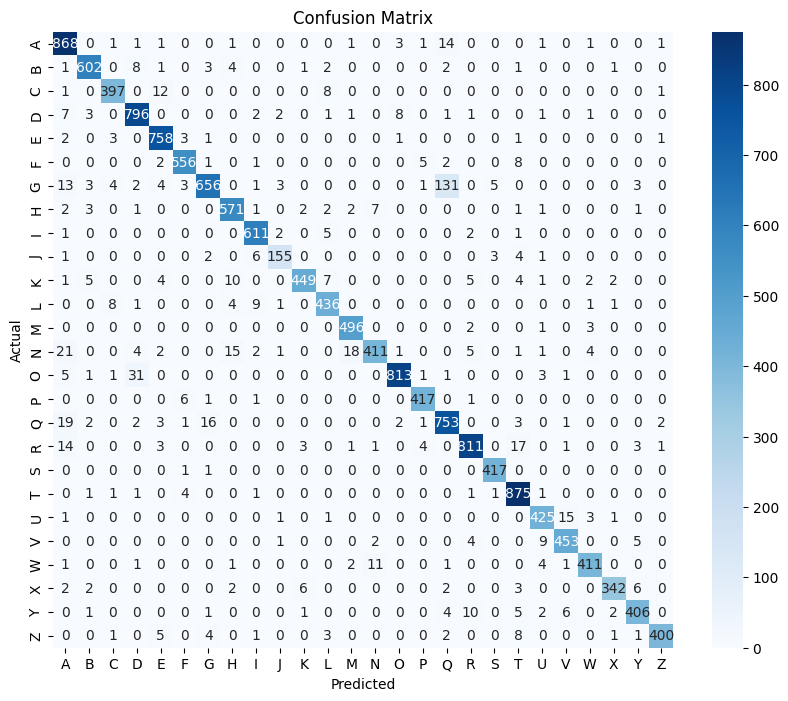

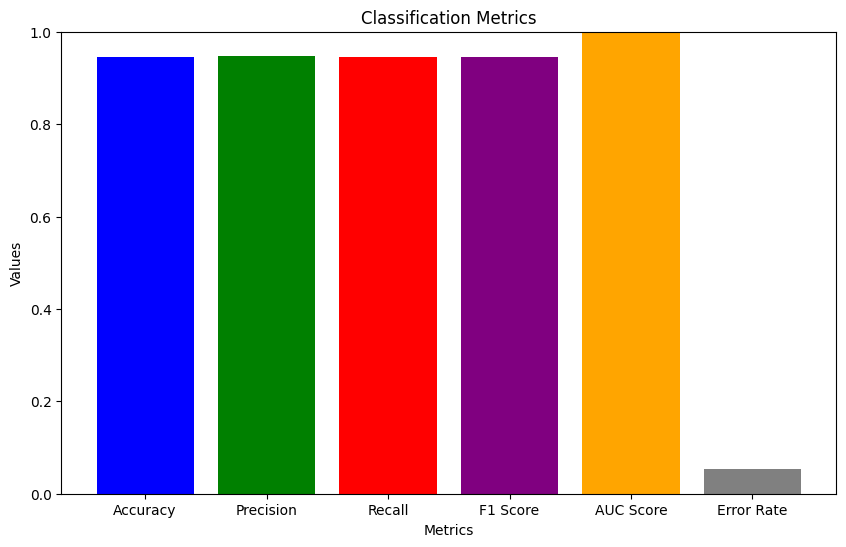

In [38]:
# Convert numerical labels to alphabets
def index_to_alphabet(index):
    return string.ascii_uppercase[index]

# Predict labels for the validation data
val_pred = model.predict(val_X)
val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = np.argmax(val_Y, axis=1)

# Convert numerical labels to alphabets
val_pred_labels_alphabet = [index_to_alphabet(label) for label in val_pred_labels]
val_true_labels_alphabet = [index_to_alphabet(label) for label in val_true_labels]

# Compute confusion matrix
conf_matrix = confusion_matrix(val_true_labels_alphabet, val_pred_labels_alphabet)

# Compute accuracy
accuracy = accuracy_score(val_true_labels_alphabet, val_pred_labels_alphabet)

# Compute precision
precision = precision_score(val_true_labels_alphabet, val_pred_labels_alphabet, average='weighted')

# Compute recall
recall = recall_score(val_true_labels_alphabet, val_pred_labels_alphabet, average='weighted')

# Compute F1 score
f1 = f1_score(val_true_labels_alphabet, val_pred_labels_alphabet, average='weighted')

# Compute specificity
true_negatives = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
false_positives = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
false_negatives = np.diag(conf_matrix) - true_negatives
true_positives = np.diag(conf_matrix)
specificity = true_negatives / (true_negatives + false_positives)

# Compute error rate
error_rate = 1 - accuracy

# Calculate AUC Score for each class and average
roc_auc = roc_auc_score(np.eye(26)[val_true_labels], val_pred, multi_class='ovr')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Error Rate:", error_rate)
print("AUC Score:", roc_auc)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(string.ascii_uppercase), yticklabels=list(string.ascii_uppercase))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Prepare data for bar graph
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score', 'Error Rate']
values = [accuracy, precision, recall, f1, roc_auc, error_rate]

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange', 'gray'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classification Metrics')
plt.ylim(0, 1)  # Set the limits of y-axis from 0 to 1
plt.show()


### Model evaluation with Test dataset

In [31]:
# Performing evaluation of the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_X, test_Y)

# Displaying the loss and accuracy results
print('Model evaluation with Test dataset')
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9386 - loss: 0.2443
Model evaluation with Test dataset
Test Loss: 0.24754667282104492
Test Accuracy: 0.9388560056686401


### ROC Curve
* Label Binarization: Convert class labels to binary labels for each class (one-hot encoding).
* ROC Calculation: For each class, calculate the false positive rate (fpr), true positive rate (tpr), and area under the curve (roc_auc).
* Plotting: For each class, a ROC curve is plotted. Additionally, a macro-average ROC curve is computed by * averaging the tprs at each fpr level across all classes.
* Macro-average: The average is taken over all classes to summarize the overall performance across all classifications.

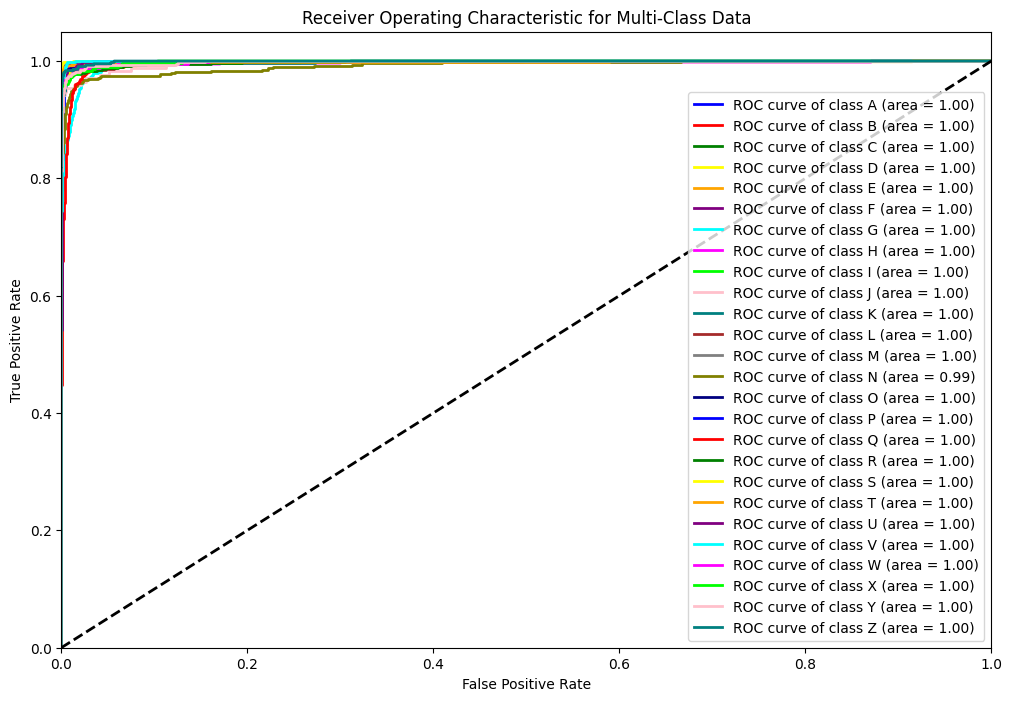

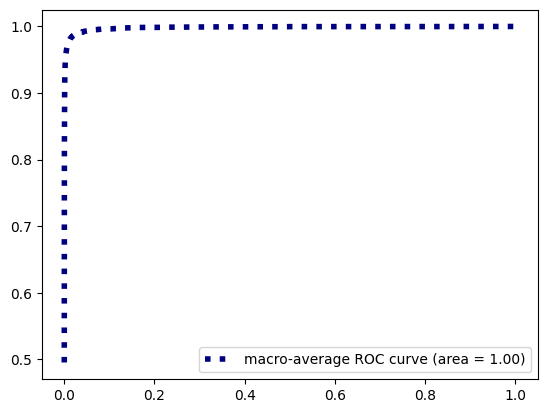

In [48]:
# Binarize the labels in a one-vs-all fashion
y_bin = label_binarize(val_Y, classes=list(range(26)))

# Compute ROC curve and ROC area for each class
n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'brown', 'gray', 'olive', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(string.ascii_uppercase[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.legend(loc="lower right")
plt.show()


### 

### Precision_recall Curve
* Precision and Recall: These metrics are computed for each class using precision_recall_curve. The area under each curve is also calculated with average_precision_score.
* Plotting: A separate Precision-Recall curve for each class is plotted with different colors.
* Macro Average: To compute the macro-average Precision-Recall curve, all precision and recall values are combined, sorted, and then the maximum precision for each recall value is computed. The area under this curve gives the macro-average precision, which summarizes performance across all classes.

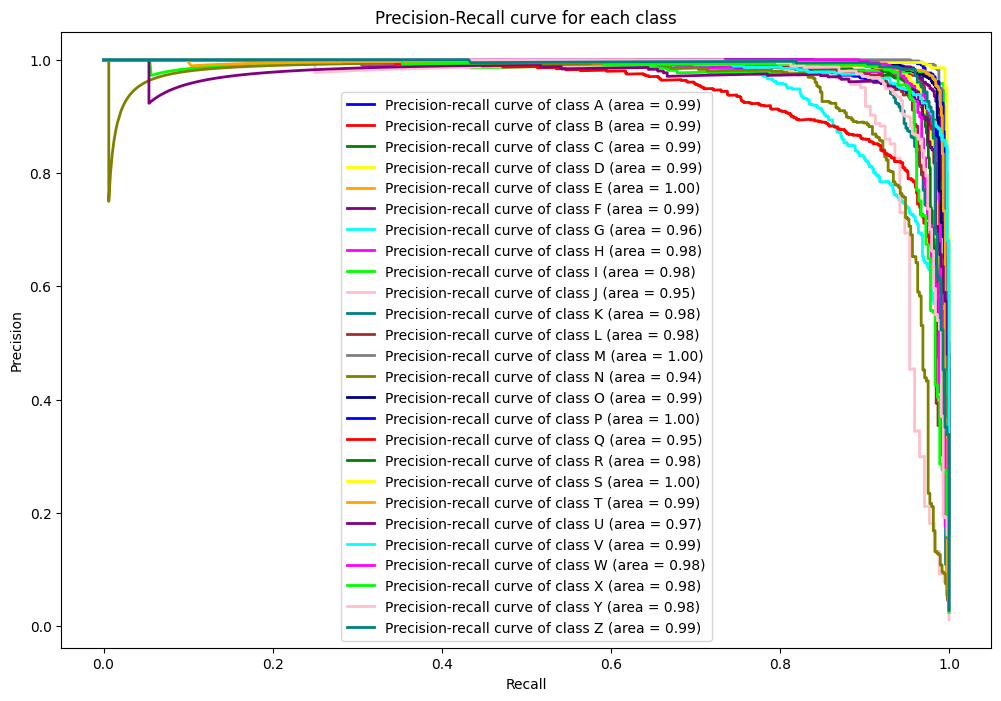

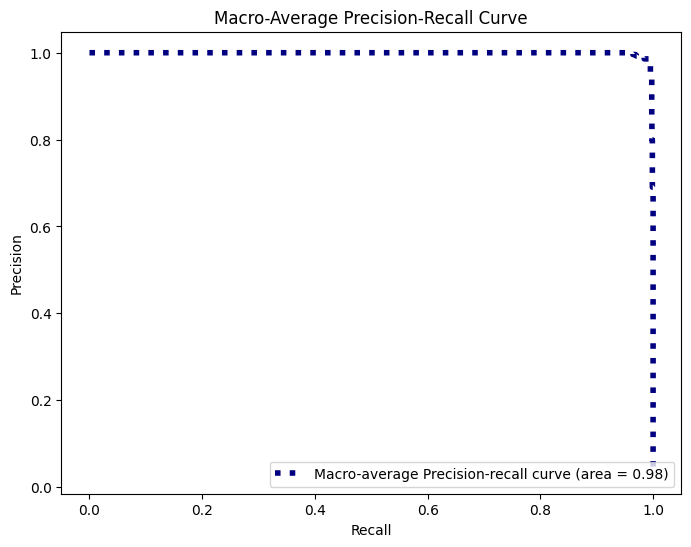

In [50]:

# Compute Precision-Recall and plot for each class
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'pink', 'teal', 'brown', 'gray', 'olive', 'navy'])

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], val_pred[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], val_pred[:, i])
    plt.plot(recall[i], precision[i], color=next(colors), lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(string.ascii_uppercase[i], average_precision[i]))

# Plot all Precision-Recall curves
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="lower center")
plt.show()

# Compute macro-average Precision-Recall curve
# Concatenate all the precision and recall data
all_precision = np.concatenate([precision[i] for i in range(n_classes)])
all_recall = np.concatenate([recall[i] for i in range(n_classes)])

# Sort all recall values and calculate precision at each step
sorted_indices = np.argsort(all_recall)
all_recall_sorted = all_recall[sorted_indices]
all_precision_sorted = all_precision[sorted_indices]

macro_precision = np.maximum.accumulate(all_precision_sorted[::-1])[::-1]
macro_recall = np.sort(all_recall_sorted)

# Compute area under the curve
macro_average_precision = average_precision_score(y_bin, val_pred, average="macro")

# Plot the macro-average Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(macro_recall, macro_precision,
         label='Macro-average Precision-recall curve (area = {0:0.2f})'.format(macro_average_precision),
         color='navy', linestyle=':', linewidth=4)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Average Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()
